In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random
import tensorflow as tf

In [111]:
cat_path = "C:/Users/erand/OneDrive - University of Jaffna/myGit/Cat-and-Dog-detection-ML-model/assignment/dataset/Cats"
dog_path = "C:/Users/erand/OneDrive - University of Jaffna/myGit/Cat-and-Dog-detection-ML-model/assignment/dataset/Dogs"
ds = "C:/Users/erand/OneDrive - University of Jaffna/myGit/Cat-and-Dog-detection-ML-model/assignment/dataset"

In [112]:
print(len(os.listdir(cat_path)))
print(len(os.listdir(dog_path)))

530
220


In [113]:
for folder in ['train', 'validation', 'test']:
    for subfolder in ['cats', 'dogs']:
        os.makedirs(os.path.join(ds, folder, subfolder), exist_ok=True)

In [114]:
def split_data(source, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.2, 0.1)):
    files = os.listdir(source)
    random.shuffle(files)
    train_size = int(len(files) * split_ratio[0])
    val_size = int(len(files) * split_ratio[1])
    test_size = len(files) - train_size - val_size

    for i, file in enumerate(files):
        if i < train_size:
            shutil.copy(os.path.join(source, file), os.path.join(train_dir, file))
        elif i < train_size + val_size:
            shutil.copy(os.path.join(source, file), os.path.join(val_dir, file))
        else:
            shutil.copy(os.path.join(source, file), os.path.join(test_dir, file))

In [115]:
split_data(cat_path, 
           os.path.join(ds, 'train', 'cats'), 
           os.path.join(ds, 'validation', 'cats'), 
           os.path.join(ds, 'test', 'cats'))

# Split dog images
split_data(dog_path, 
           os.path.join(ds, 'train', 'dogs'), 
           os.path.join(ds, 'validation', 'dogs'), 
           os.path.join(ds, 'test', 'dogs'))

In [116]:
print(len(os.listdir(os.path.join(ds, 'train', 'cats'))))
print(len(os.listdir(os.path.join(ds, 'train', 'dogs'))))
print(len(os.listdir(os.path.join(ds, 'validation', 'cats'))))
print(len(os.listdir(os.path.join(ds, 'validation', 'dogs'))))

530
220
526
217


In [117]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

con_base = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten()
])

In [119]:
con_base.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 256)     

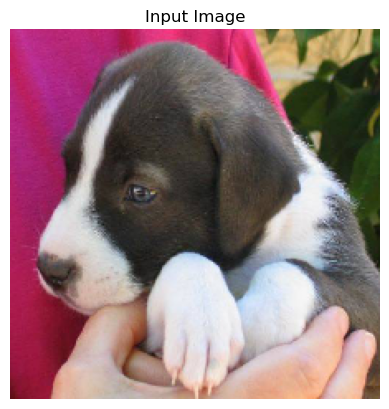

In [120]:
testImg = load_img("dataset/test/dogs/dog.891.jpg" , target_size = (224,224))

testImg = img_to_array(testImg)
testImg = np.expand_dims(testImg , axis=0)
testImg/=255.0

plt.imshow(testImg[0])
plt.title("Input Image")
plt.axis("off")
plt.show()

In [121]:
prediction = con_base.predict(testImg)

1/1 [==============================] - 0s 83ms/step


In [122]:
reduced_prediction = prediction[0].reshape(7, 7, 512)

In [124]:
#reduced_prediction = np.mean(prediction[0], axis=-1)
#plt.matshow(reduced_prediction,cmap='viridis')
#plt.title("Reduced Prediction Heatmap")
#plt.colorbar()
#plt.show()

In [125]:
con_base.trainable = False

model = models.Sequential()
model.add(con_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [126]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [127]:
print(len(model.trainable_weights))

4


In [128]:
con_base.trainable=False

In [129]:
train_ds = r"C:\Users\erand\OneDrive - University of Jaffna\myGit\Cat-and-Dog-detection-ML-model\assignment\dataset\train"
validation_ds = r"C:\Users\erand\OneDrive - University of Jaffna\myGit\Cat-and-Dog-detection-ML-model\assignment\dataset\validation"
test_ds = r"C:\Users\erand\OneDrive - University of Jaffna\myGit\Cat-and-Dog-detection-ML-model\assignment\dataset\test"

In [130]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

train_generator = train_datagen.flow_from_directory(
    train_ds,
    target_size=(224, 224),  # Updated size to match VGG16 input
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_ds,
    target_size=(224, 224),  # Updated size to match VGG16 input
    batch_size=32,
    class_mode='binary'
)


Found 748 images belonging to 2 classes.
Found 741 images belonging to 2 classes.


In [131]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [132]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluation
test_generator = test_datagen.flow_from_directory(
    test_ds,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
23/23 [==============================] - 9s 370ms/step - loss: 0.6259 - accuracy: 0.7067 - val_loss: 0.6158 - val_accuracy: 0.7079
Epoch 2/10
23/23 [==============================] - 8s 349ms/step - loss: 0.6168 - accuracy: 0.7067 - val_loss: 0.6122 - val_accuracy: 0.7079
Epoch 3/10
23/23 [==============================] - 8s 338ms/step - loss: 0.6158 - accuracy: 0.7039 - val_loss: 0.6170 - val_accuracy: 0.7079
Epoch 4/10
23/23 [==============================] - 8s 349ms/step - loss: 0.6113 - accuracy: 0.7095 - val_loss: 0.6074 - val_accuracy: 0.7079
Epoch 5/10
23/23 [==============================] - 8s 339ms/step - loss: 0.6158 - accuracy: 0.7081 - val_loss: 0.6149 - val_accuracy: 0.7079
Epoch 6/10
23/23 [==============================] - 8s 347ms/step - loss: 0.6123 - accuracy: 0.7081 - val_loss: 0.6057 - val_accuracy: 0.7079
Epoch 7/10
23/23 [==============================] - 8s 351ms/step - loss: 0.6077 - accuracy: 0.7095 - val_loss: 0.6032 - val_accuracy: 0.7092
Epoch 

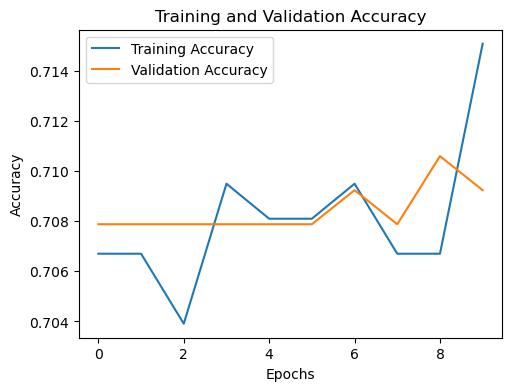

In [133]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


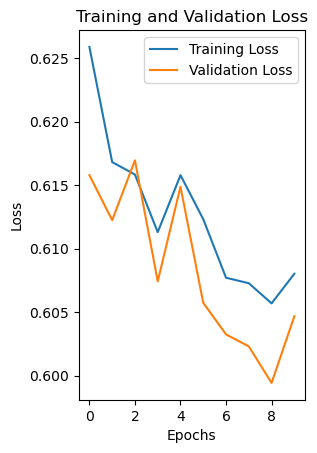

In [134]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [135]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

21/21 [==============================] - 1s 60ms/step


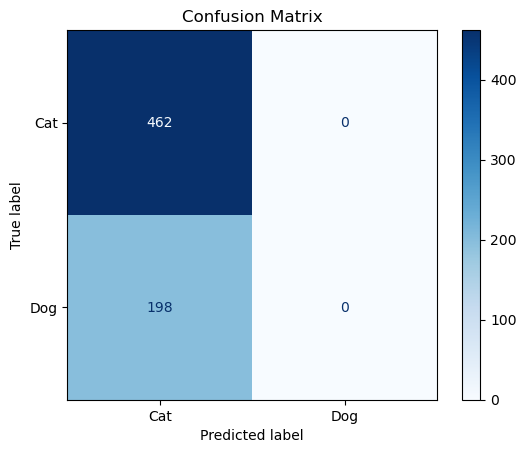

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [137]:
model.save('cat_dog_classifier.h5')

In [138]:
from tensorflow.keras.models import load_model

loaded_model = load_model('cat_dog_classifier.h5')
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 25088)             3910784   
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,333,825
Trainable params: 6,423,041
Non-trainable params: 3,910,784
_________________________________________________________________


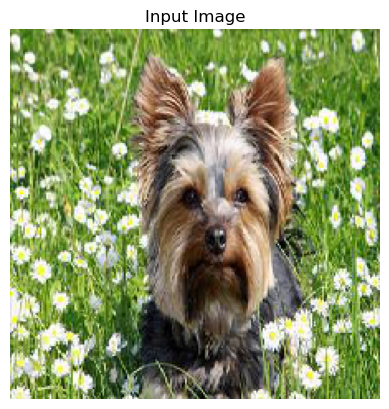

1/1 [==============================] - 0s 88ms/step
Predicted: Cat


In [139]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load image from file path
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    return 'Dog' if prediction > 0.5 else 'Cat'

image_path = r"C:\Users\erand\OneDrive - University of Jaffna\myGit\Cat-and-Dog-detection-ML-model\assignment\b.jpg"
testImg = load_img(image_path, target_size=(224, 224))
testImg = img_to_array(testImg)
testImg = np.expand_dims(testImg, axis=0)
testImg /= 255.0

plt.imshow(testImg[0])
plt.title("Input Image")
plt.axis("off")
plt.show()

result = predict_image(image_path)
print(f"Predicted: {result}")


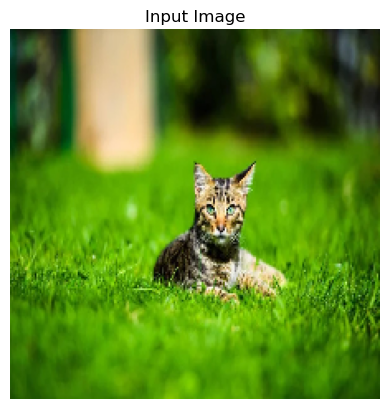

1/1 [==============================] - 0s 25ms/step
Predicted: Cat


In [140]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load image from file path
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    return 'Dog' if prediction > 0.5 else 'Cat'

image_path = r"C:\Users\erand\OneDrive - University of Jaffna\6sem\DL\aa.jpg"
testImg = load_img(image_path, target_size=(224, 224))
testImg = img_to_array(testImg)
testImg = np.expand_dims(testImg, axis=0)
testImg /= 255.0

plt.imshow(testImg[0])
plt.title("Input Image")
plt.axis("off")
plt.show()

result = predict_image(image_path)
print(f"Predicted: {result}")